<img src="https://raw.githubusercontent.com/MLMI2-CSSI/foundry/main/assets/foundry-black.png" width=450>

# Foundry Dendrite Segmentation Tutorial for Beginners

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MLMI2-CSSI/foundry/blob/main/examples/dendrite-segmentation/dendrite_segmentation.ipynb)

This introduction uses Foundry to:


1.   Load data from Foundry
2.   Build a predictuve U-Net model
3. Create augmented data to use with the model

This notebook is set up to run as a [Google Colaboratory](https://colab.research.google.com/notebooks/intro.ipynb#scrollTo=5fCEDCU_qrC0) notebook, which allows you to run python code in the browser, or as a [Jupyter](https://jupyter.org/) notebook, which runs locally on your machine.

The code in the next cell will detect your environment to make sure that only cells that match your environment will run.

In [1]:
try:
    import google.colab
    no_local_server=True
    no_browser=True
    globus=False
except: # when not in google colab
    no_local_server=False
    no_browser=False
    globus=True

# Installing Foundry and Other Modules
First we'll need to install Foundry as well as a few other packages. If you're using Google Colab, this code block will install these packages into the Colab environment.

If you are running locally, it will install these modules onto your machine if you do not already have them. We also have a [requirements file](https://github.com/MLMI2-CSSI/foundry/tree/main/examples/dendrite-segmentation) included with this notebook. You can run `pip install -r requirements.txt` in your terminal to set up your environment locally.

In [2]:
#!pip install scikit-learn
#!pip install foundry_ml
#!pip install scikit-image
#!pip install tensorflow
#!pip install keras-unet
#!pip install opencv-python

#if in Google Colab, you'll need these pinned
#versions since Colab keeps theirs a few behind
#!pip install pandas==1.2.2 tables==3.6.1

# Importing Packages
Now we can import Foundry, which will allow us to load the data. 

We'll be using [scikit-image](https://scikit-image.org/) for image processing; [Keras](https://keras.io/) and [TensorFlow](https://www.tensorflow.org/) to create our model; and [pandas](https://pandas.pydata.org/), [OpenCV](https://pypi.org/project/opencv-python/), and [NumPy ](https://numpy.org/)to work with our data.

In [3]:
from foundry import Foundry
from skimage.io import imshow, imread
from keras_unet.models import custom_unet
import matplotlib.pyplot as plt
from keras_unet.utils import plot_imgs
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance
from keras_unet.utils import get_augmented

c:\Users\taylo\miniconda3\envs\MatInformatics\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


# Instantiating Foundry
To instantiate Foundry, you'll need a [Globus](https://www.globus.org) account. Once you have your account, you can instantiate Foundry using the code below. When you instantiate Foundry locally, be sure to have your Globus endpoint turned on (you can do that with [Globus Connect Personal](https://www.globus.org/globus-connect-personal)). When you instantiate Foundry on Google Colab, you'll be given a link in the cell's output and asked to enter the provided auth code.


In [4]:
f = Foundry(index="mdf", no_local_server=no_local_server, no_browser=no_browser)

# Loading the Data
Now we can use our instance of Foundry to load the data using `f.load()`. Once the data is loaded and accessible, we load the data into the client using `f.load_data()`.

Heads up, the data is about 700MB size

In [6]:
f.load("foundry_stan_segmentation_v1.1", globus=False)

Starting Download of: https://data.materialsdatafacility.org/foundry/foundry_stan_segmentation_v1.1/foundry.hdf5
Downloading... 697.82 MB

Foundry(dc={'identifier': {'identifier': '10.18126/d4kn-cz3p', 'identifierType': 'DOI'}, 'rightsList': [{'rights': 'CC-BY 4.0'}], 'creators': [{'creatorName': 'Stan, Tiberiu', 'affiliations': ['Northwestern University'], 'familyName': 'Stan', 'givenName': 'Tiberiu'}, {'creatorName': 'Thompson, Zach', 'affiliations': ['Northwestern University'], 'familyName': 'Thompson', 'givenName': 'Zach'}, {'creatorName': 'Voorhees, Peter', 'affiliations': ['Northwestern University'], 'familyName': 'Voorhees', 'givenName': 'Peter'}], 'subjects': [{'subject': 'machine learning'}, {'subject': 'foundry'}, {'subject': 'segmentation'}, {'subject': 'metals and alloys'}], 'publicationYear': 2021, 'publisher': 'Materials Data Facility', 'dates': [{'date': '2021-07-26', 'dateType': 'Accepted'}], 'titles': [{'title': 'Dataset for Semantic Segmentation of Dendrites via Machine Learning'}], 'resourceType': {'resourceTypeGeneral': 'Dataset', 'resourceType': 'Dataset'}}, mdf={'resource_type': 'dataset', 'organizations': ['Foundry'], 'ingest_date': '2021-07-26T18:25:34.286195Z', 'source_id': 'foundry_stan_segmentation_v1.1', 'scroll_id': 0, 'version': 1, 'source_name': 'foundry_stan_segmentation'}, dataset=FoundryDataset(keys=[FoundryKey(key=['train/input'], type='input', classes=None, description='input, unlabeled images', filter=None, units=''), FoundryKey(key=['train/output'], type='target', classes=None, description='target, labeled images', filter=None, units='')], splits=[FoundrySplit(type='train', path='foundry.hdf5', label='train')], data_type=<FoundryDatasetType.hdf5: 'hdf5'>, short_name='segmentation', dataframe=None, task_type=['unsupervised', 'segmentation'], domain=['materials science', 'chemistry'], n_items=30), config=FoundryConfig(dataframe_file='foundry_dataframe.json', data_file='foundry.hdf5', metadata_file='foundry_metadata.json', destination_endpoint=None, local=False, local_cache_dir='./data', metadata_key='foundry', organization='foundry'), forge_client=<mdf_forge.forge.Forge object at 0x000002831E51A980>, connect_client=<mdf_connect_client.mdfcc.MDFConnectClient object at 0x000002832BD8CC40>, transfer_client=<globus_sdk.services.transfer.client.TransferClient object at 0x000002832BD8CCD0>, auth_client=<globus_sdk.services.auth.client.service_client.AuthClient object at 0x000002832BD8C370>, index='mdf', auths={'openid': <globus_sdk.authorizers.refresh_token.RefreshTokenAuthorizer object at 0x000002831E5B5A50>, 'data_mdf': <globus_sdk.authorizers.refresh_token.RefreshTokenAuthorizer object at 0x000002831E51A2C0>, 'petrel': <globus_sdk.authorizers.refresh_token.RefreshTokenAuthorizer object at 0x000002831E5199C0>, 'https://auth.globus.org/scopes/82f1b5c6-6e9b-11e5-ba47-22000b92c6ec/https': <globus_sdk.authorizers.refresh_token.RefreshTokenAuthorizer object at 0x000002832BD8CAF0>, 'search': <globus_sdk.services.search.client.SearchClient object at 0x000002831E51AD40>, 'mdf_connect': <globus_sdk.authorizers.refresh_token.RefreshTokenAuthorizer object at 0x000002832BD8C3D0>, 'transfer': <globus_sdk.services.transfer.client.TransferClient object at 0x000002832BD8CCD0>, 'https://auth.globus.org/scopes/d31d4f5d-be37-4adc-a761-2f716b7af105/action_all': <globus_sdk.authorizers.refresh_token.RefreshTokenAuthorizer object at 0x000002832BD8CD30>, 'https://auth.globus.org/scopes/f10a69a9-338c-4e5b-baa1-0dc92359ab47/https': <globus_sdk.authorizers.refresh_token.RefreshTokenAuthorizer object at 0x000002832BD8CD00>, 'search_authorizer': <globus_sdk.authorizers.refresh_token.RefreshTokenAuthorizer object at 0x000002832BD8CB80>})

In [7]:
res = f.load_data()
X = res['train']['input']['train/input']
y = res['train']['target']['train/output']

# Visualizing the Data

Now that we've loaded the data, let's take a look!

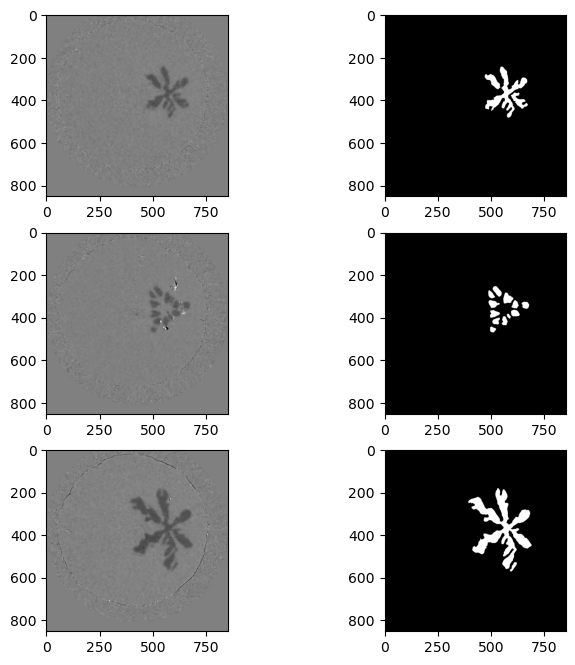

In [8]:
fig, axs = plt.subplots(3,2, figsize=(8,8))
for i in range(3):
    axs[i][0].imshow(X[i])
    axs[i][1].imshow(y[i])

# Building a Model
## Resize to Match UNet
UNet requires images to be of a size multiple of 32, so we'll resize them here.

In [9]:
new_size = 32*10 # U-Net requires a multiple of 32

X_r = np.array([cv2.resize(img, dsize=(new_size, new_size)) 
     for img in X])
y_r = np.array([cv2.resize(mask, dsize=(new_size, new_size)) 
     for mask in y])

In [10]:
y_r.shape

(30, 320, 320, 3)

## Create UNet Model

In [11]:
input_shape = (new_size,new_size,3)

model = custom_unet(input_shape)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 320, 320, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 320, 320, 16)         432       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 320, 320, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 spatial_dropout2d (Spatial  (None, 320, 320, 16)         0         ['batch_normalization[0][0

# Preview the Segmentation Task

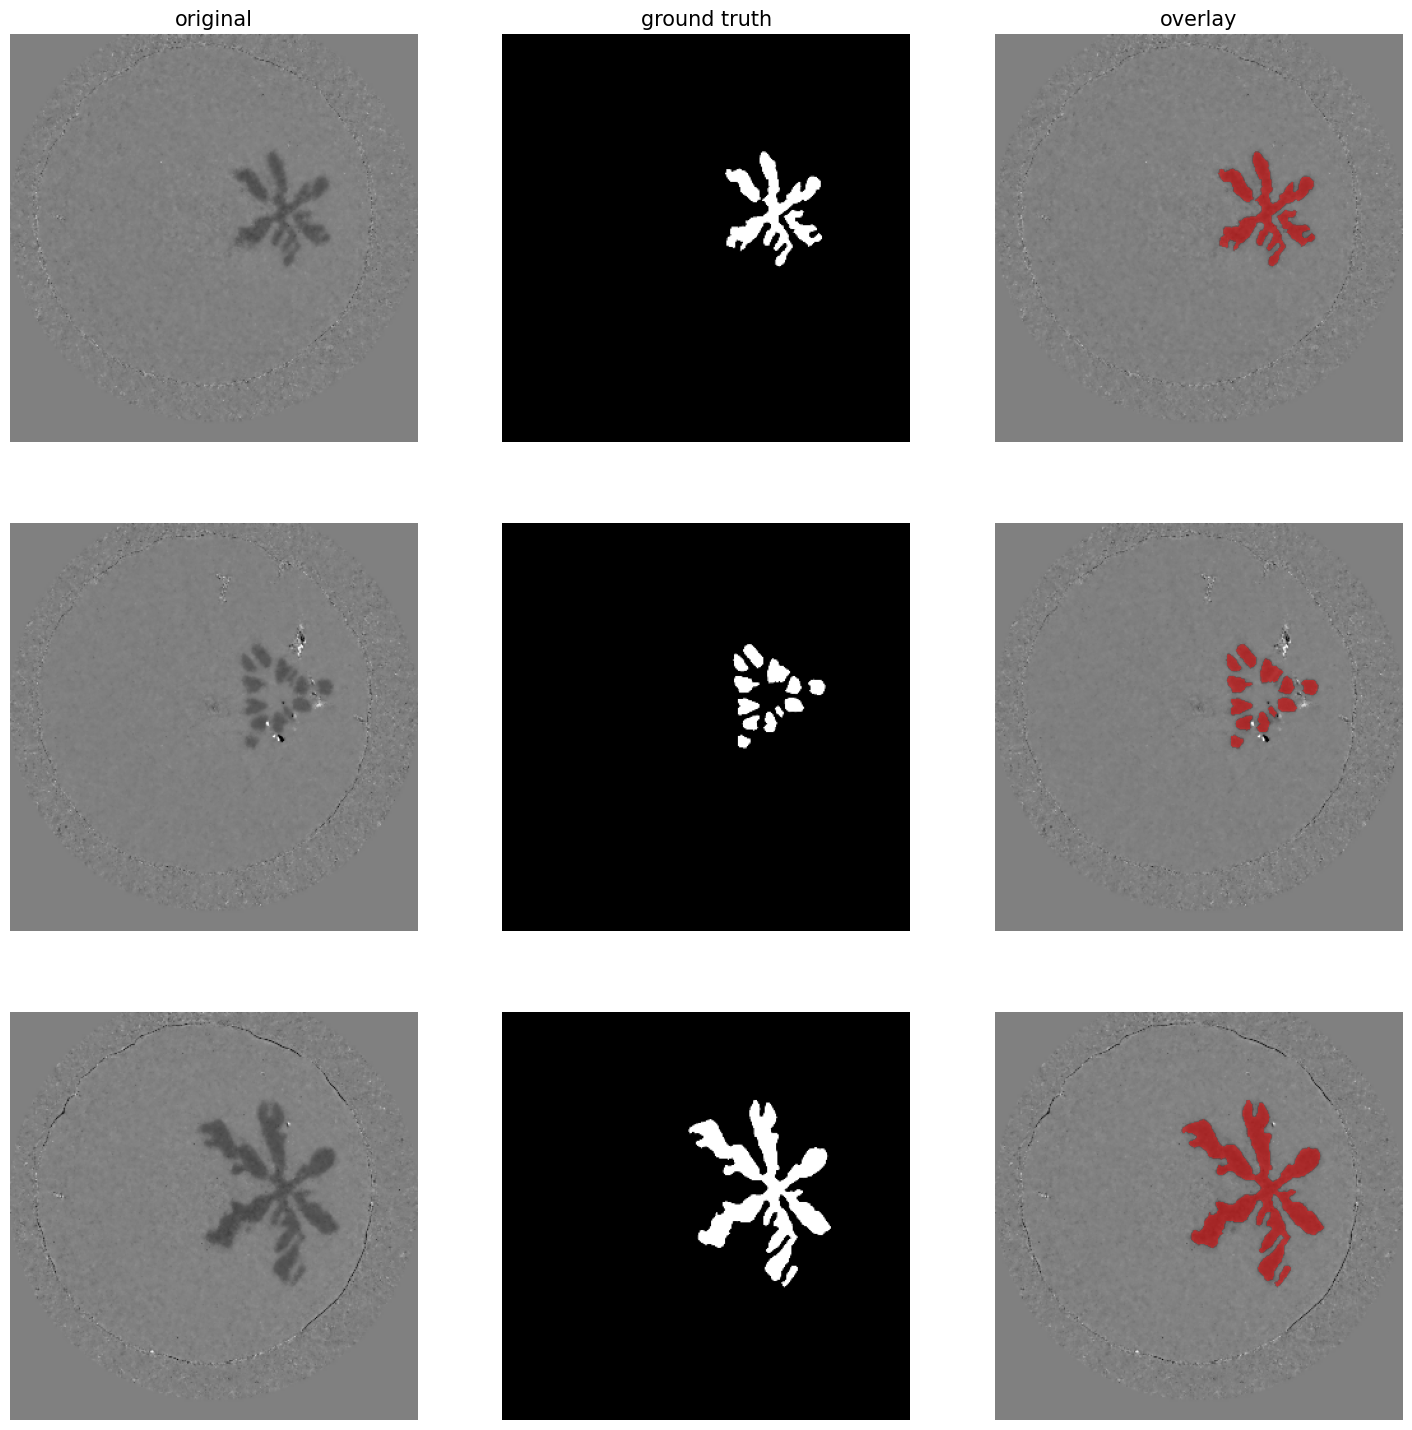

In [13]:
plot_imgs(org_imgs=X_r, mask_imgs=y_r[:,:,:,0], nm_img_to_plot=3, figsize=6)

# Create a Generator with Augmented Images

In [14]:
X_r.shape

(30, 320, 320, 3)

In [15]:
y_r.shape

(30, 320, 320, 3)

In [16]:
n_images = 30
y_c = y_r[:,:,:,0]

train_gen = get_augmented(
    X_r, np.reshape(y_c, (n_images, new_size, new_size, 1)), batch_size=2,
    data_gen_args = dict(
        rotation_range=5.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=30,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

# Preview Augmented Images

(2, 320, 320, 3) (2, 320, 320, 1)


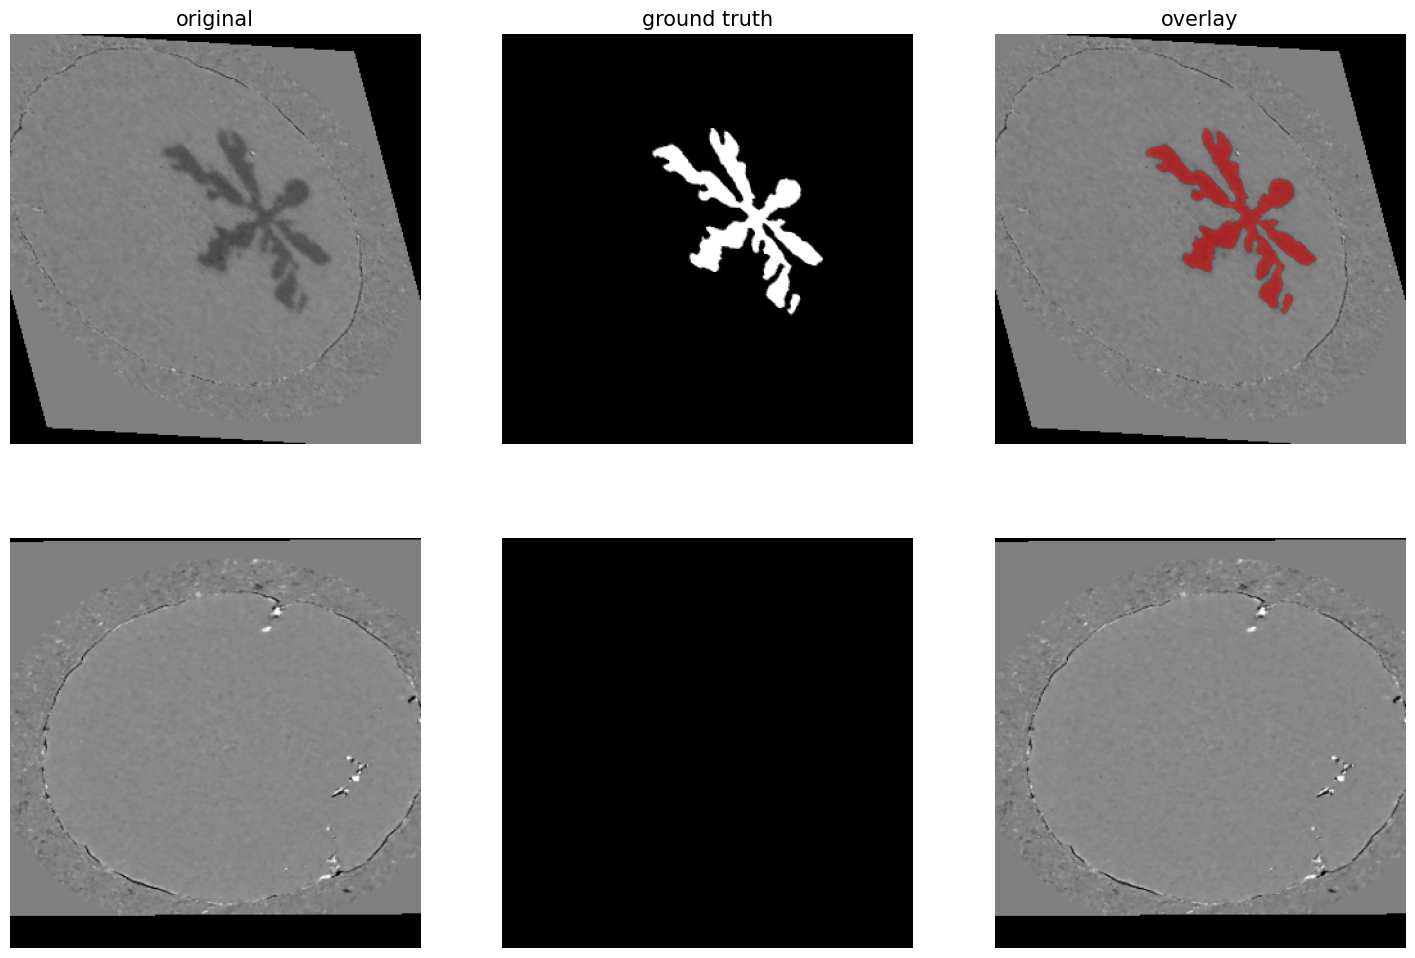

In [17]:
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy[:,:,:,0], nm_img_to_plot=2, figsize=6)

# Compile Model

In [18]:
model.compile(
    optimizer="adam", 
    #optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    #loss=jaccard_distance,
    metrics=[tf.keras.metrics.MeanIoU(num_classes=2)]
)

# Fit Model

In [19]:
history = model.fit(
train_gen,
    steps_per_epoch=200,
    epochs=10
)

Epoch 1/10

200/200 [==============================] - 111s 492ms/step - loss: 0.3669 - mean_io_u: 0.5773
Epoch 2/10
200/200 [==============================] - 65s 323ms/step - loss: 0.1087 - mean_io_u: 0.7193
Epoch 3/10
200/200 [==============================] - 101s 506ms/step - loss: 0.0549 - mean_io_u: 0.7072
Epoch 4/10
200/200 [==============================] - 64s 319ms/step - loss: 0.0511 - mean_io_u: 0.6062
Epoch 5/10
200/200 [==============================] - 65s 324ms/step - loss: 0.0267 - mean_io_u: 0.5944
Epoch 6/10
200/200 [==============================] - 64s 320ms/step - loss: 0.0304 - mean_io_u: 0.5963
Epoch 7/10
200/200 [==============================] - 64s 319ms/step - loss: 0.0242 - mean_io_u: 0.5331
Epoch 8/10
200/200 [==============================] - 99s 495ms/step - loss: 0.0182 - mean_io_u: 0.5287
Epoch 9/10
200/200 [==============================] - 73s 363ms/step - loss: 0.0173 - mean_io_u: 0.5310
Epoch 10/10
200/200 [==============================] - 64s 32

In [20]:
model_name = f"./{new_size}x{new_size}-model.h5"
model.save(model_name) 

c:\Users\taylo\miniconda3\envs\MatInformatics\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
model = tf.keras.models.load_model(model_name)

# Run Predict on Images

In [22]:
y_pred = model.predict(X_r)

1/1 [==============================] - 3s 3s/step


# Check Performance Visually

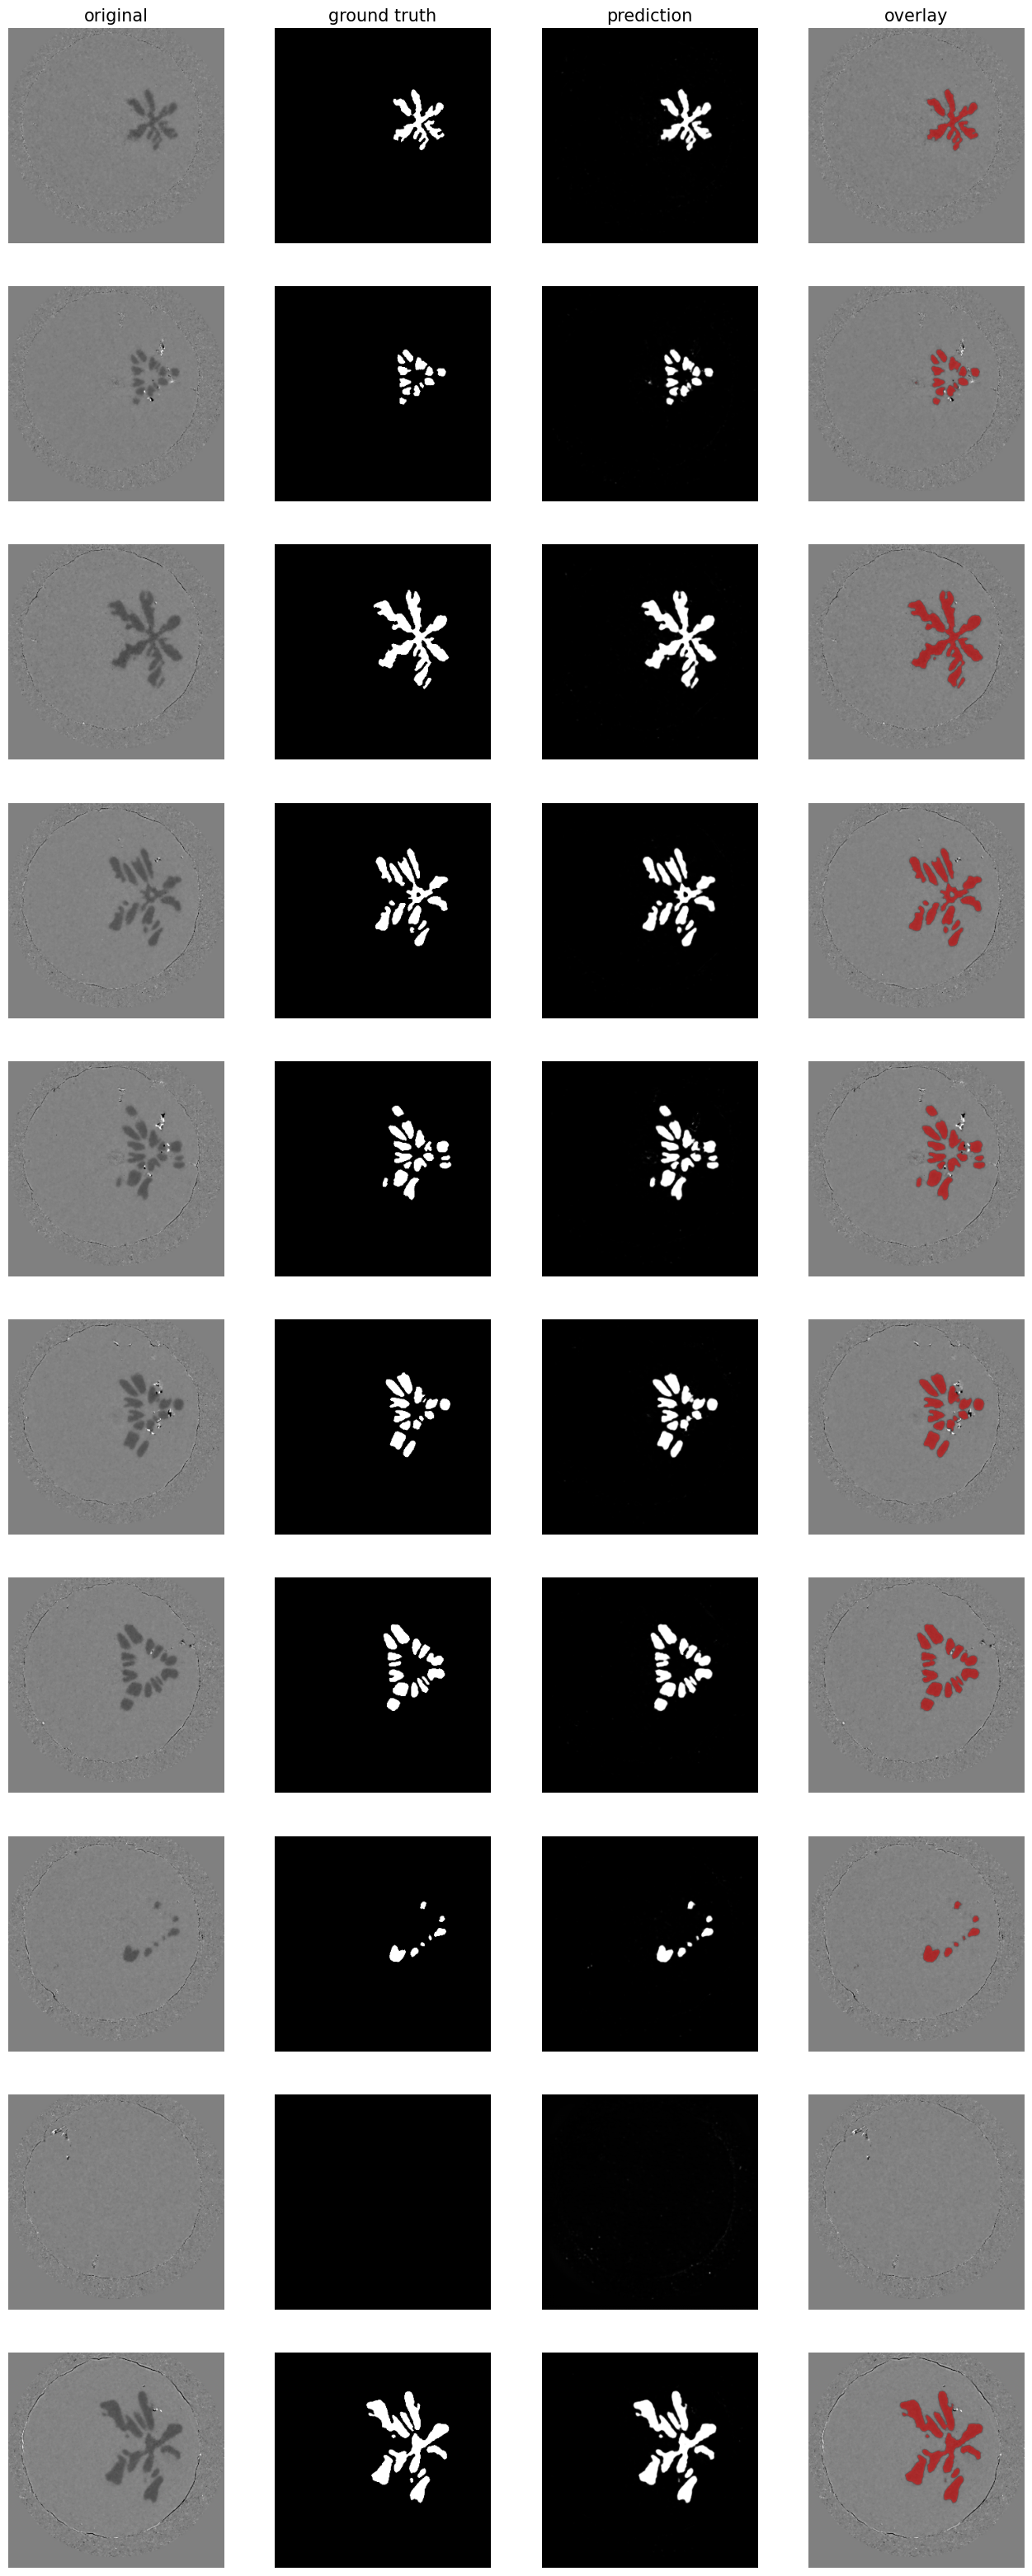

In [23]:
plot_imgs(org_imgs=X_r, mask_imgs=y_c, pred_imgs=y_pred, nm_img_to_plot=10)